In [228]:
%load_ext autoreload

%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from copy import deepcopy

import matplotlib.pyplot as plt
import imageio
from PIL import Image
from datetime import datetime
from tqdm import tqdm

from IPython.display import display, clear_output
import time

from cppn_protyper import CPPN, Sampler, multiscale_targets_apply

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [459]:
# net_size = [1024, 32, 256, 16, 128, 6]
net_size = [512, 32, 256, 16, 128, 6, 6, 6, 6, 6, 6]
# net_size = [128, 128, 64, 64, 32, 32, 16, 8]
# net_size = np.tile([256, 16, 8], 2)
# net_size = [32, 64, 128, 512, 256, 128, 64, 32]
# net_size = [512, 64, 32, 16, 8]
# net_size = [512, 32, 32, 16] ## pretty
# net_size = [512, 32, 32, 3] 
# net_size = [512, 16, 512, 32, 16, 3]  ## also pretty
# net_size = [512, 16, 512, 32, 8, 3]  ## also pretty
# net_size = [512, 64, 64, 3]  # also pretty
# net_size = [512, 64, 64, 6, 6, 6, 6, 6]
# net_size = [256, 128, 128, 6, 6, 6, 6]
# net_size = [256,256, 16, 16, 3]
# net_size = [128, 160, 200, 4]
# net_size = [128, 64, 32, 16, 16, 2]  ## also pretty
# net_size = [32, 32, 32]
# net_size = [128, 128, 128, 128, 128]
dim_z = 16
dim_c = 3
# proj_dims = [int(3)]
proj_dims = [100]
proj_scales = [5. for i in proj_dims]
projection_config = (proj_dims, proj_scales)
print(net_size)

cppn = CPPN(net_size, dim_z, dim_c, projection_config=projection_config).cuda()
sampler = Sampler(cppn)

[512, 32, 256, 16, 128, 6, 6, 6, 6, 6, 6]


# Generate Image

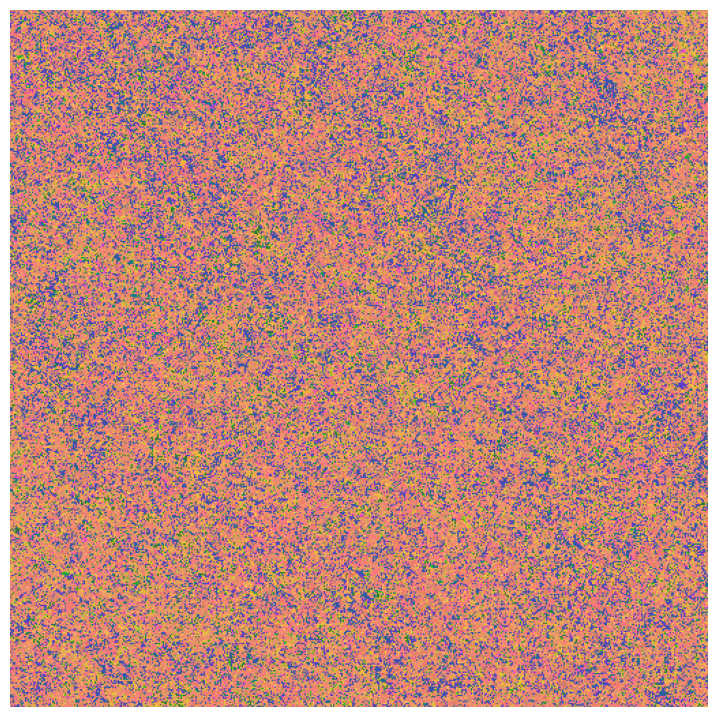

In [460]:
# projection_config = None
cppn = CPPN(net_size, dim_z, dim_c, projection_config=projection_config).cuda()
sampler = Sampler(cppn)
cppn.reinit(empty_cache=True)

gscale = 1
scale = 10
xres = 512
yres = int(512*1 )
zscale = 1.
nscale = 0

z =  torch.randn(1, dim_z).cuda()
delta_v = torch.randn(1, dim_z).cuda() 
# delta_v = delta_v / torch.norm(delta_v)
z2 = z + 0.02*delta_v
coords = cppn._coordinates(scale*gscale,
                           xres, yres, z*zscale*gscale)

coords[2] = coords[2] * 0.

cppn.eval()
x = sampler.generate_img(cppn, z*zscale, scale, xres, yres, coords=coords)
sampler.imshow(x[:, :, 0:3])

# Train

In [375]:
target_file = 'target/pug.png'
img = Image.open(target_file)
img_mean = np.mean(img)
img_std = np.std(img)
# img = (img - np.mean(img)) / np.std(img)
shape = np.array(img).shape
aspectratio = shape[0] / shape[1]
MSELoss = nn.MSELoss()

In [367]:
torch.cuda.empty_cache()
del TARGET, x, out

In [371]:
for name, params in cppn.named_parameters():
    params.requires_grad=True

In [369]:
for name, params in cppn.named_parameters():
    if ('rule.projection_seq' not in name) and ('rule.in_coords' not in name):
        params.requires_grad=False
    print(f'{name}: {params.requires_grad}')

rule.frequencies: False
rule.phases: False
rule.projection_seq.0.weight: True
rule.projection_seq.0.bias: True
rule.projection_seq.1.weight: True
rule.projection_seq.1.bias: True
rule.in_coords.weight: True
rule.in_z.weight: False
rule.seq.0.lin.weight: False
rule.seq.0.lin.bias: False
rule.seq.1.lin.weight: False
rule.seq.1.lin.bias: False
rule.seq.2.lin.weight: False
rule.seq.2.lin.bias: False
rule.seq.3.lin.weight: False
rule.seq.3.lin.bias: False
rule.seq.4.weight: False


In [370]:
for name, params in cppn.named_parameters():
    if 'rule.seq.5.weight' in name:
        params.requires_grad=False
    print(f'{name}: {params.requires_grad}')

rule.frequencies: False
rule.phases: False
rule.projection_seq.0.weight: True
rule.projection_seq.0.bias: True
rule.projection_seq.1.weight: True
rule.projection_seq.1.bias: True
rule.in_coords.weight: True
rule.in_z.weight: False
rule.seq.0.lin.weight: False
rule.seq.0.lin.bias: False
rule.seq.1.lin.weight: False
rule.seq.1.lin.bias: False
rule.seq.2.lin.weight: False
rule.seq.2.lin.bias: False
rule.seq.3.lin.weight: False
rule.seq.3.lin.bias: False
rule.seq.4.weight: False


2580


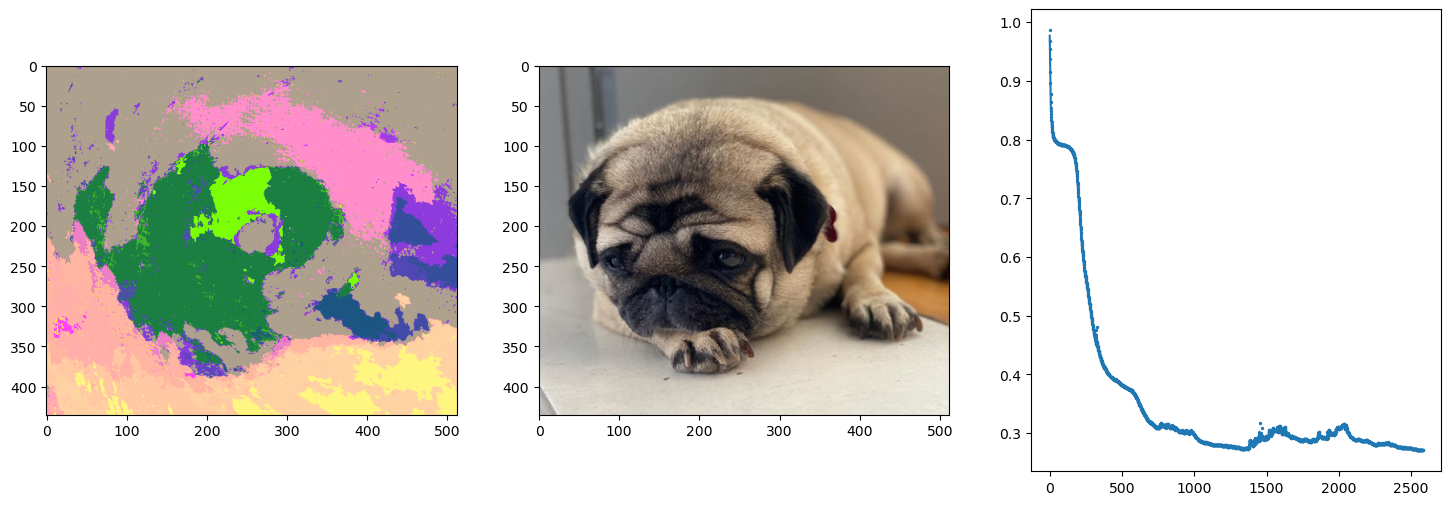

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [461]:
EPOCHS= 20000
XRES=512
YRES=int(XRES * aspectratio)
BATCH_SIZE=1

MASK_INDEX = 0

TARGET = np.array(img.resize((XRES, YRES), Image.ANTIALIAS))
mask = torch.cuda.FloatTensor(TARGET[:, :, MASK_INDEX] > -1).reshape(-1)
mask = mask.unsqueeze(0).unsqueeze(-1)

TARGET = TARGET[:, :, :3].reshape(1, -1, 3).astype('float64')
# TARGET = TARGET/TARGET.max()
TARGET = torch.cuda.FloatTensor(np.tile(TARGET, (BATCH_SIZE, 1, 1)))

losses = []
var_z = 0.0 # variation in latent vector z across batch  

### FREEZE LAYERS
toggle_freeze = False
sparsity = 0.5

if toggle_freeze:    
    for m in cppn.rule.children():
        for l in m.children():
            if np.random.random() < sparsity:
                for p in l.parameters():
                    p.requires_grad = False
            else:
                for p in l.parameters():
                    p.requires_grad = True 
                    

multiscale_target = False
big_factor = 0.5
change_target_time = 500
keep_full = True
num_full = 1



multiscale = False
scale_range = 1

scale_in = scale
zscale = zscale
# z = torch.randn(BATCH_SIZE, dim_z).cuda()
z_in = zscale * z.repeat(BATCH_SIZE, 1)


optim = torch.optim.Adam(cppn.parameters(), lr=1e-3)
# optim = torch.optim.LBFGS(, lr=1e-3)
lambda1 = lambda epoch: 1 / (1 + epoch // 1000)
scheduler = torch.optim.lr_scheduler.LambdaLR(optim, lr_lambda=lambda1)
need_new_grid = True


learn_z = nn.Parameter()

for epoch in range(EPOCHS):
    optim.zero_grad()
    
#     z_in = zscale * torch.randn(BATCH_SIZE, dim_z).cuda()

    
    delta_z = var_z*torch.randn(BATCH_SIZE, dim_z).cuda()
    zt = z_in + delta_z

    if need_new_grid:
        
        x = cppn._coordinates(scale_in, xres=XRES, yres=YRES, z=zt, batch_size=BATCH_SIZE)
        # x[3] = x[3] * 0. # remove radial
        if multiscale_target:
            x, TARGET = multiscale_targets_apply(x, img, XRES, YRES, BATCH_SIZE, big_factor, keep_full, num_full)
        
        if multiscale and not multiscale_target: # both multiscaling can't be on at the same time
            scale_factor = 10**( scale_range * (np.random.uniform(size=BATCH_SIZE) - 1/2) )[:,  np.newaxis, np.newaxis]
            x[0] = x[0]*scale_factor
            x[1] = x[1]*scale_factor
            x[2] = x[2]*np.sqrt(scale_factor)
            x[-1] = x[-1]*torch.from_numpy(scale_factor).float().cuda()
            
        need_new_grid = False
    else:
        x = x[:-1]
        x.append(zt.unsqueeze(1))  # remove z layer inputs and replace with new z
        
        if multiscale:
            x[-1] = x[-1]*torch.from_numpy(scale_factor).float().cuda()



    out = cppn.forward(x, XRES, YRES)
    
    
#     out_masked = out * mask
#     TARGET = TARGET * mask
#     loss = -ssim_loss(out.reshape(BATCH_SIZE, YRES, XRES, 3) , TARGET.reshape(-1, YRES, XRES, 3))
    # loss = -ssim_loss(out.mean(2).reshape(BATCH_SIZE, YRES, XRES, 1) , TARGET.mean(2).reshape(-1, YRES, XRES, 1))
    out = (out - out.mean(dim=[1, 2], keepdim=True)) / out.std(dim=[1, 2], keepdim=True)
    target = (TARGET - img_mean) / img_std
    # loss = MSELoss(out, target)
    loss = MSELoss(out.mean(2), target.mean(2))
#     loss = MSELoss(out.unsqueeze(1), TARGET.unsqueeze(1))
    loss.backward()
    optim.step()
    scheduler.step()
    
    losses.append(loss.item())
    

    
    if multiscale_target and epoch % change_target_time == 0:
        x = cppn._coordinates(scale_in, xres=XRES, yres=YRES, z=zt, batch_size=BATCH_SIZE)
        x, TARGET = multiscale_targets_apply(x, img, XRES, YRES, BATCH_SIZE, big_factor, keep_full, num_full)   
    
    if epoch % 30 == 0:
        alpha = 0.5
#         rand_ind = np.random.randint(len(out))
        rand_ind = 0
        nx = (out[rand_ind].detach().cpu().numpy().reshape(YRES, XRES, -1) * img_std) + img_mean
        s_losses = alpha * np.array(losses[:-1]) + (1 - alpha) * np.array(losses[1:])

        plt.clf()
        fig, ax = plt.subplots(1, 3, figsize=(18, 6))
        ax[0].imshow(nx / 255.)
        ax[2].plot(s_losses)
        ax[2].scatter(np.arange(len(losses)), losses, s=2)
        ax[1].imshow(TARGET[rand_ind].cpu().numpy().reshape(YRES, XRES, 3) / 255.)

        clear_output(wait=True)
        print(f'{epoch}')
        display(plt.gcf())
        time.sleep(0.001)
        plt.close()
        
    if epoch % 4000 == 0 and epoch != 0:
        XRES += 4
        YRES += 4 
        need_new_grid = True
        
        TARGET = np.array(img.resize((XRES, YRES), Image.ANTIALIAS))        
        mask = torch.cuda.FloatTensor(TARGET[:, :, MASK_INDEX] > 1e-5).reshape(-1)
        mask = mask.unsqueeze(0).unsqueeze(-1)
        
        TARGET = TARGET[:, :, :3].reshape(1, -1, 3).astype('float64')

        TARGET = torch.cuda.FloatTensor(TARGET)
        
        
        
    
    

## Hires

100%|██████████| 5/5 [00:00<00:00, 16.09it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2180, 2560, 3)


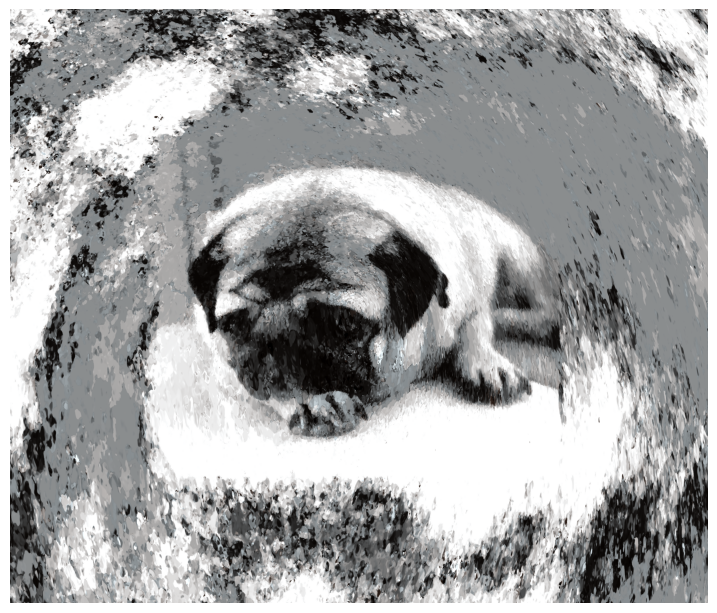

In [448]:
x_reps = 5
y_reps = 5
x_dim = 512
y_dim = int(512 * aspectratio)

scale_hires = scale*gscale * 1.75
z_hires = z*zscale*gscale
coords_hires = cppn._coordinates(scale_hires, x_reps*x_dim, y_reps*y_dim, z_hires, flatten=False)
# coords_hires[0] = np.abs(coords_hires[0])
# coords_hires[0] = 2*np.cos(0.5*np.abs(coords_hires[0]))
# coords_hires[1] = 2*np.cos(0.5*np.abs(coords_hires[1]))


# crop = int((512*16 - 512*9)/2)
# coords_hires[-2] = nscale*scale*np.array(n_hires)[crop:-crop, :][np.newaxis, :]

# coords[0] = coords[0] + np.cos(coords[0]/2)
# coords[1] = coords[1] + np.sin(coords[1]/2)
# coords[3] = coords[3].cpu().numpy() * (1 + 1/coords[2])

x = sampler.generate_hires(cppn, z=z_hires, scale=scale, x_dim=x_dim, y_dim=y_dim, x_reps=x_reps, y_reps=y_reps, coords=coords_hires)
x = (x - x.mean()) / x.std()
x = ((x * img_std) + img_mean) / 255.
print(x.shape)
sampler.imshow(x)
  
time_str = datetime.now().strftime("%y-%m-%d-%H-%M-%S.%f")
figname = 'hi_res/' + time_str + '.png'
# imageio.imwrite(figname, (x * 255).astype(np.uint8), format='png')

In [440]:
figname = 'hi_res/' + time_str + '.png'
imageio.imwrite(figname, np.clip((x * 255.), 0, 255.).astype(np.uint8), format='png')